# CNAK

In [1]:
# import libraries
import os
import glob
import sys
import warnings
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

warnings.filterwarnings(action='once')


import cnak module

In [2]:
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.cnak import cnak

## Load datasets

Glob all processed csv files

In [3]:
df_lst = []
for file in glob.glob("../../data/processed/*.csv"):
    print(file)
    df = pd.read_csv(file,index_col=[0])
    df_lst.append(df)

../../data/processed/mall_customers_data.csv
../../data/processed/country_data.csv
../../data/processed/customer_data.csv


In [4]:
# dataframes of each datasets in X and y (if available)
X_mall_customers = df_lst[0].reset_index(drop=True)

X_country = df_lst[1].reset_index(drop=True)

X_customer = df_lst[2].iloc[:,:-1].reset_index(drop=True)
y_customer = df_lst[2]['Region']

## Train CNAK to obtain optimal cluster number, K
We will run CNAK 50 times to determine which is the optimal cluster number (k) for Kmeans.

In [5]:
X_dict = {
    'mall_customers': X_mall_customers,
    'country': X_country,
    'customer': X_customer
}

In [6]:
def run_cnak(X_dict:dict, gamma:float=0.7, num_iter:int=50) -> dict:
    """
    Function run cnak 
    """
    data_cluster_dict = {} # initialise empty dictionary to store optimal cluster number for each dataset after 50 runs
    for counter, (dataset_name, X) in enumerate(X_dict.items(), start=1):
        print(f"Dataset: {dataset_name} - [{counter}/{len(X_dict)}]")
        cluster_lst = [] # initialise empty list to store clusters number for each run
        for _ in tqdm(range(num_iter)): # 50 iterations
            labels, scores, centers = cnak.CNAK(np.array(X), gamma=gamma, k_min=2)
            clusters = len(set(labels)) # number of clusters
            cluster_lst.append(clusters) # append to list

        clusters_df = pd.DataFrame(cluster_lst).value_counts().reset_index()
        clusters_df.columns = ['clusters','count']
        data_cluster_dict[dataset_name] = clusters_df.loc[clusters_df['count'] == clusters_df['count'].max()]['clusters'][0] # find optimal cluster 

    return data_cluster_dict

In [7]:
data_cluster_dict = run_cnak(X_dict=X_dict, gamma=1, num_iter=50)

Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

optimal cluster number for each dataset

In [8]:
data_cluster_dict

{'mall_customers': 2, 'country': 2, 'customer': 2}

the dictionary below is a manual collation of optimal cluster number for kmeans using other methods such as elbow or silhouette score

In [9]:
norm_cluster_dict = {'mall_customers': 5, 'country': 3, 'customer': 2}

## Evaluation

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import mutual_info_score, adjusted_rand_score

In [11]:
def evaluate_cnak (dataset_name:str, dataset_clusters:dict, X:pd.DataFrame, y:pd.Series=None)->list:

    metrics_lst = []
    for k, clusters in dataset_clusters.items():
        kmeans = KMeans(n_clusters=clusters,random_state=0, n_init="auto").fit(X)
        labels = kmeans.labels_

        metrics = []
        # Calculate clustering metrics
        silhouette = silhouette_score(X, np.array(labels))
        db_index = davies_bouldin_score(X, np.array(labels))
        ch_index = calinski_harabasz_score(X, np.array(labels))
        ari = None
        mi = None

        if y is not None:
            ari = adjusted_rand_score(y, np.array(labels))
            mi = mutual_info_score(y, np.array(labels))

        metrics.append([dataset_name, clusters, silhouette,db_index,ch_index, ari, mi])

        metrics_df = pd.DataFrame(data=metrics, columns=['dataset_name','clusters','silhouette','db_index','ch_index', 'ari', 'mi'], index=[k])
        metrics_lst.append(metrics_df)
    
    return pd.concat(metrics_lst)

In [12]:
mall_customers_clusters = {
    'cnak':10,
    'without_cnak': 5
}

customer_clusters = {
    'cnak':2,
    'without_cnak': 2
}

country_clusters = {
    'cnak':2,
    'without_cnak': 3
}

In [37]:
is_cnak_clusters_df

,is_cnak,variable,value
0,cnak,mall_customers_clusters,10
1,without_cnak,mall_customers_clusters,5
2,cnak,customer_clusters,2
3,without_cnak,customer_clusters,2
4,cnak,country_clusters,2
5,without_cnak,country_clusters,3


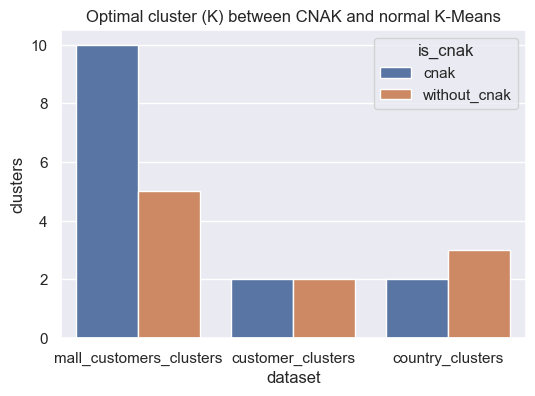

In [44]:
is_cnak_clusters_df = pd.DataFrame({
                        'mall_customers_clusters':mall_customers_clusters,
                        'customer_clusters': customer_clusters,
                        'country_clusters':country_clusters
                    }).reset_index(names='is_cnak').melt(id_vars='is_cnak')
is_cnak_barplot = sns.barplot(data=is_cnak_clusters_df,x='variable',y='value',hue='is_cnak')
is_cnak_barplot.set(
    xlabel='dataset',
    ylabel='clusters',
    title='Optimal cluster (K) between CNAK and normal K-Means'
)
plt.savefig("../../assets/cnak/is_cnak_barplot.png")

In [13]:
mall_customers_metrics = evaluate_cnak(
    dataset_name='mall_customers',
    dataset_clusters=mall_customers_clusters,
    X=X_mall_customers)
customer_metrics = evaluate_cnak(
    dataset_name='customers',
    dataset_clusters=customer_clusters,
    X=X_customer, 
    y=y_customer)
country_metrics = evaluate_cnak(
    dataset_name='country',
    dataset_clusters=country_clusters,
    X=X_country)

In [14]:
dataset_metrics = pd.concat([mall_customers_metrics,customer_metrics, country_metrics])
dataset_metrics

/var/folders/g4/mj9t8ccd7bn74b0c25x8xjth0000gn/T/ipykernel_3677/2119167317.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset_metrics = pd.concat([mall_customers_metrics,customer_metrics, country_metrics])


,dataset_name,clusters,silhouette,db_index,ch_index,ari,mi
cnak,mall_customers,10,0.404981,0.885440,85.125508,NaN,NaN
without_cnak,mall_customers,5,0.317807,1.156509,68.980518,NaN,NaN
cnak,customers,2,0.406829,1.123881,195.070388,-0.017812,0.003447
without_cnak,customers,2,0.406829,1.123881,195.070388,-0.017812,0.003447
cnak,country,2,0.572717,0.647933,32.064753,NaN,NaN
without_cnak,country,3,0.368971,0.839504,88.591953,NaN,NaN


Visualisations

In [15]:
dataset_metrics_melted = dataset_metrics.drop(['clusters'],axis=1).reset_index(names='use_cnak').melt(id_vars=['use_cnak','dataset_name'])

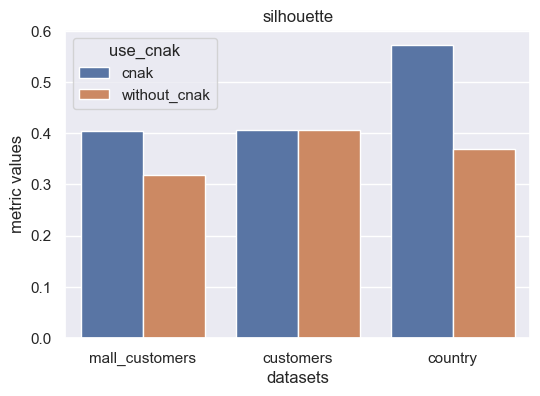

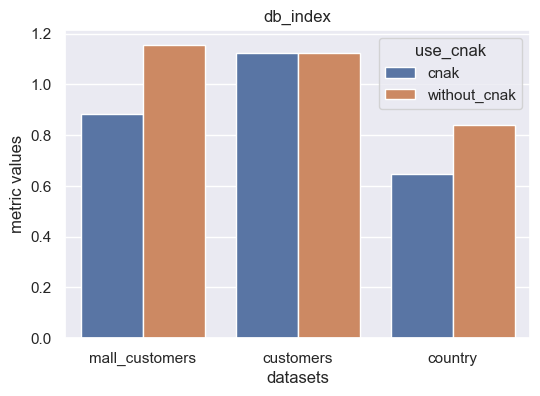

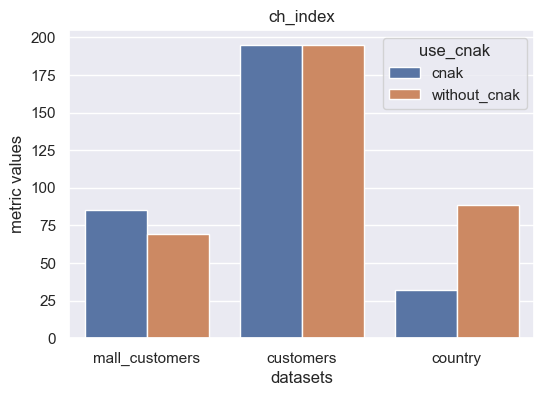

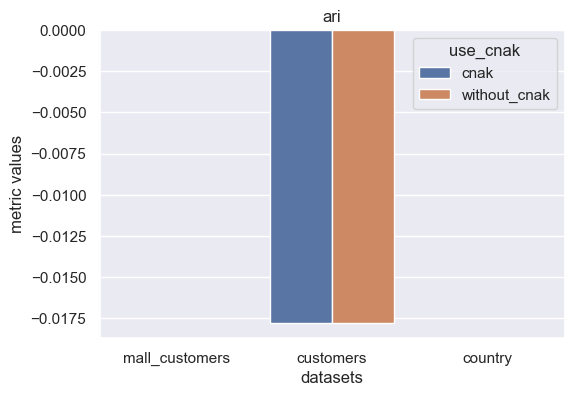

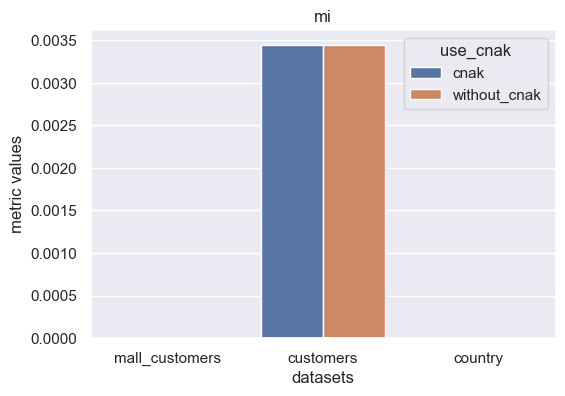

In [16]:
sns.set_theme(rc={'figure.figsize':(6,4)})
for i, metric in enumerate(dataset_metrics_melted.variable.unique(), start=0):
    dataset_metric = dataset_metrics_melted.loc[dataset_metrics_melted['variable']==metric]
    bar_plot = sns.barplot(data=dataset_metric, x='dataset_name',y='value',hue='use_cnak')
    bar_plot.set(xlabel='datasets',ylabel='metric values', title=metric)
    # 
    plt.savefig(f"../../assets/cnak/{metric}.png")
    plt.show()


## Hyperparameter Tuning

There is 1 hyperparameter available to tune the CNAK algorithm - gamma. 

This parameter is essentially a heuristics to determine ths sampling size in a multi-dimensional space. The size of the sampled datasets is critical as its size influences any statistical estiamte directly. Hence, using a heuristics is important as by estimating an optimal sample size that is representative of the dataset, this arbritrary selection makes computation more efficienct and reliable. Using a large sample size will naturally lead to a better estimate but at the expense of efficiency and reliability. 

The authors decided to extend the theory of determiming sample size for a unidimensional random variable to that of a multi-dimensional variable in forming a heuristic.

In [17]:
data_cluster_nested_dicts = {} # initialise empty list to store dictionaries of optimal dataset
for counter, gamma in enumerate(np.linspace(0.5,1,6), start=1):
    print(f"Gamma: {gamma}")
    print(f"Start - [{counter}/6]")
    data_cluster_dict = {} # initialise empty dictionary to store optimal cluster number for each dataset after 50 runs

    data_cluster_dict = run_cnak(X_dict=X_dict, gamma=gamma, num_iter=50)
    data_cluster_nested_dicts[gamma] = data_cluster_dict

    print(f"Gamma: {gamma}, End - [{counter}/6]")

Gamma: 0.5
Start - [1/6]
Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Gamma: 0.5, End - [1/6]
Gamma: 0.6
Start - [2/6]
Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Gamma: 0.6, End - [2/6]
Gamma: 0.7
Start - [3/6]
Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Gamma: 0.7, End - [3/6]
Gamma: 0.8
Start - [4/6]
Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Gamma: 0.8, End - [4/6]
Gamma: 0.9
Start - [5/6]
Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Gamma: 0.9, End - [5/6]
Gamma: 1.0
Start - [6/6]
Dataset: mall_customers - [1/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: country - [2/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Dataset: customer - [3/3]


  0%|          | 0/50 [00:00<?, ?it/s]

Gamma: 1.0, End - [6/6]


In [18]:
data_cluster_nested_dicts

{0.5: {'mall_customers': 10, 'country': 2, 'customer': 2},
 0.6: {'mall_customers': 2, 'country': 2, 'customer': 2},
 0.7: {'mall_customers': 10, 'country': 2, 'customer': 2},
 0.8: {'mall_customers': 2, 'country': 2, 'customer': 2},
 0.9: {'mall_customers': 2, 'country': 2, 'customer': 2},
 1.0: {'mall_customers': 2, 'country': 2, 'customer': 2}}

In [27]:
data_clusters_melted = pd.DataFrame(data=data_cluster_nested_dicts).reset_index(names='dataset').melt(id_vars='dataset')

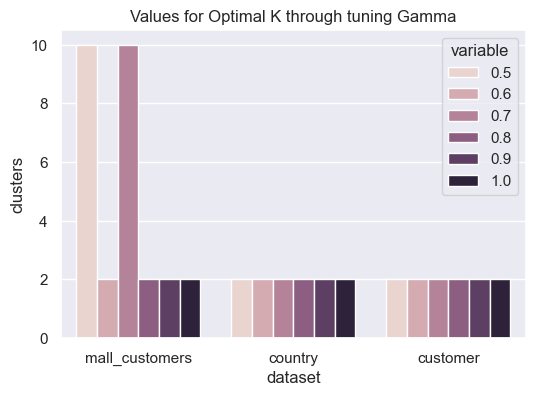

In [43]:
data_clusters_barplot = sns.barplot(data_clusters_melted,x='dataset',y='value',hue='variable')
data_clusters_barplot.set(
    ylabel='clusters',
    title='Values for Optimal K through tuning Gamma'
)
plt.savefig(("../../assets/cnak/data_clusters_barplot.png"))

Only mall_customer dataset had a difference in cluster numbers, mostly due to further reduction in sample size which led to change in underlying data distribution. Theeotically, higher gamma values means more data is used which should lead to a more accurate and stable result. 

In [19]:
mall_customers_clusters_gamma = {
    'gamma_05':10,
    'gamma_1': 2
}

In [20]:
mall_customers_metrics = evaluate_cnak(
    dataset_name='mall_customers_gamma',
    dataset_clusters=mall_customers_clusters_gamma,
    X=X_mall_customers)

In [21]:
mall_customers_metrics

,dataset_name,clusters,silhouette,db_index,ch_index,ari,mi
gamma_05,mall_customers_gamma,10,0.404981,0.885440,85.125508,None,None
gamma_1,mall_customers_gamma,2,0.251815,1.613751,71.020516,None,None
